In [52]:
import numpy as np
import xarray as xr
from scipy.sparse.linalg import svds
from matplotlib import pyplot as plt
import seaborn as sns
import fastplotlib as fpl
from tqdm import tqdm
from ipywidgets import interact

In [2]:
toy_shape = (2, 10_000)

Parameters:
* Noise
* Length of recording
* length of single transient
* n_steps
* delay

In [64]:
noise_magnitudes = np.arange(-2, 4, 0.5)
noise_magnitudes = 10**noise_magnitudes

recording_lengths = np.array([100, 1_000, 5_000, 10_000, 15_000])
transient_lengths = np.array([2, 3, 5, 7, 10, 15, 20, 30, 50])
n_steps = np.arange(2, 25)
delay = np.arange(1, 10)

shape = (
    len(noise_magnitudes),
    len(recording_lengths),
    len(transient_lengths),
    len(n_steps),
    len(delay)
)

In [66]:
data = np.empty(shape, dtype=object)

In [67]:
a = xr.DataArray(
    data, 
    coords={
        "noise": noise_magnitudes,
        "rlen": recording_lengths,
        "tlen": transient_lengths,
        "n_steps": n_steps,
        "delay": delay,
    },
    dims=("noise", "rlen", "tlen", "n_steps", "delay")
)

In [68]:
a

<xarray.DataArray (noise: 12, rlen: 5, tlen: 9, n_steps: 23, delay: 9)>
array([[[[[None, None, None, ..., None, None, None],
          [None, None, None, ..., None, None, None],
          [None, None, None, ..., None, None, None],
          ...,
          [None, None, None, ..., None, None, None],
          [None, None, None, ..., None, None, None],
          [None, None, None, ..., None, None, None]],

         [[None, None, None, ..., None, None, None],
          [None, None, None, ..., None, None, None],
          [None, None, None, ..., None, None, None],
          ...,
          [None, None, None, ..., None, None, None],
          [None, None, None, ..., None, None, None],
          [None, None, None, ..., None, None, None]],

         [[None, None, None, ..., None, None, None],
          [None, None, None, ..., None, None, None],
          [None, None, None, ..., None, None, None],
          ...,
...
          ...,
          [None, None, None, ..., None, None, None],
          [None, None, None, ..., None, None, None],
          [None, None, None, ..., None, None, None]],

         [[None, None, None, ..., None, None, None],
          [None, None, None, ..., None, None, None],
          [None, None, None, ..., None, None, None],
          ...,
          [None, None, None, ..., None, None, None],
          [None, None, None, ..., None, None, None],
          [None, None, None, ..., None, None, None]],

         [[None, None, None, ..., None, None, None],
          [None, None, None, ..., None, None, None],
          [None, None, None, ..., None, None, None],
          ...,
          [None, None, None, ..., None, None, None],
          [None, None, None, ..., None, None, None],
          [None, None, None, ..., None, None, None]]]]], dtype=object)
Coordinates:
  * noise    (noise) float64 0.01 0.03162 0.1 0.3162 ... 316.2 1e+03 3.162e+03
  * rlen     (rlen) int64 100 1000 5000 10000 15000
  * tlen     (tlen) int64 2 3 5 7 10 15 20 30 50
  * n_steps  (n_steps) int64 2 3 4 5 6 7 8 9 10 ... 16 17 18 19 20 21 22 23 24
  * delay    (delay) int64 1 2 3 4 5 6 7 8 9

In [22]:
p1 = 0.01
pixels = np.random.choice(a=[0, 1], size=toy_shape, p=[1-p1, p1])
pixels[1:] = pixels[0]

# pixels[1] += np.random.choice(a=[0, 1], size=(toy_shape[1]), p=[1-p_noise, p_noise])
pixels[pixels == 2] = 1

for i in range(pixels.shape[0]):
    for j in range(10):
        pixels[i] += np.roll(pixels[i], shift=1)

pixels[pixels > 1] = 1
pixels = pixels.astype(float)
# pixels *= 2

pixels_clean = pixels.copy()

for i in range(pixels.shape[0]):
    pixels[i] += np.random.normal(0, 1, size=toy_shape[1])

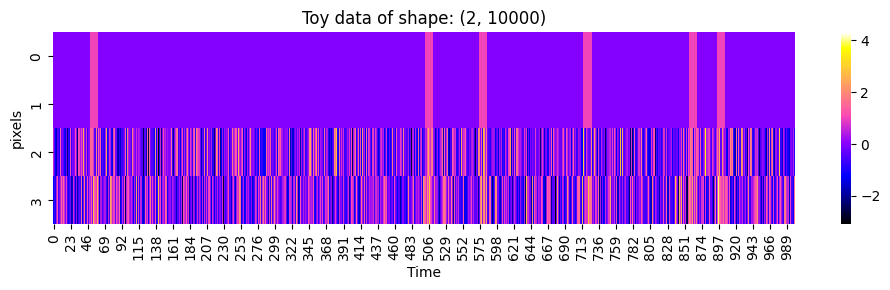

In [23]:
fig = plt.figure(figsize=(10, 3))
sns.heatmap(np.vstack([pixels_clean, pixels])[:, :1000], cmap="gnuplot2")
plt.title(f"Toy data of shape: {toy_shape}")
plt.xlabel("Time")
plt.ylabel("pixels"), pixels
plt.tight_layout()
plt.show()

In [5]:
class TdSVD:
    def __init__(
        self,
        data: np.ndarray,
        n_time_steps: int,
        delay: int,
    ):
        self.n_time_steps = n_time_steps
        
        n_timepoints = data.shape[1]
        self.n_pixels = data.shape[0]
        
        self.A = np.zeros((self.n_pixels * n_time_steps, n_timepoints - (n_time_steps * delay)), dtype=np.float32)
        
        for pixel_ix in tqdm(range(self.n_pixels)):
            for step in range(n_time_steps):
                self.A[(n_time_steps * pixel_ix) + step] = np.roll(data[pixel_ix], shift=-delay * step)[:-n_time_steps * delay]

        self.k, self.U, self.S, self.V = None, None, None, None
    
    def fit(self, k=6, **kwargs):
        self.k = k
        self.U, self.S, self.V = svds(self.A, k=k, **kwargs)
        self.U = self.U[:, ::-1]
        self.S = self.S[::-1]
        self.V = self.V[::-1, :]

    def get_spatial(self):
        return self.U.reshape(self.n_pixels, self.n_time_steps, self.k)

In [6]:
%matplotlib ipympl

In [7]:
import seaborn as sns

In [8]:
tdsvd = None

In [9]:
@interact(n_time_steps=(1, 25), delay=(1, 50), k=(2, 10))
def plot_everything(n_time_steps: int = 5, delay: int = 1, k: int = 4):
    fig = plt.figure(figsize=(15, 10))
    grid = plt.GridSpec(10, 10)
    
    toy_plot = fig.add_subplot(grid[0, :])
    sns.heatmap(np.vstack([pixels_clean]), cmap="gnuplot2", ax=toy_plot)
    toy_plot.set_title(f"Toy data of shape: {toy_shape}")
    toy_plot.set_xlabel("Time")
    toy_plot.set_ylabel("pixels")

    toy_plot_noise = fig.add_subplot(grid[1:2, :])
    sns.heatmap(np.vstack([pixels]), cmap="gnuplot2", ax=toy_plot_noise)
    toy_plot_noise.set_title(f"Toy data  + noise: {toy_shape}")
    toy_plot_noise.set_xlabel("Time")
    toy_plot_noise.set_ylabel("pixels")

    global tdsvd
    tdsvd = TdSVD(pixels, n_time_steps=n_time_steps, delay=delay)
    tdsvd.fit(k=k)
    
    plot_embed = fig.add_subplot(grid[2:7, :])
    sns.heatmap(tdsvd.A[:, :200], cmap="gnuplot2", ax=plot_embed)
    plot_embed.set_title(f"Time embedding, shape: {tdsvd.A.shape}, n_steps: {tdsvd.n_time_steps}")
    plot_embed.set_xlabel("Time")
    plot_embed.set_ylabel("pixels over steps")
    
    plot_svals = fig.add_subplot(grid[8:, :3])
    plot_svals.scatter(np.arange(tdsvd.S.size), tdsvd.S / tdsvd.S.max())
    plot_svals.set_yscale("log")
    for x, y in zip(np.arange(tdsvd.S.size), tdsvd.S):
        plot_svals.annotate(f"{y:.2e}", (x + 0.05, y))
    
    plot_svals.set_title(f"Singular values: {np.array2string(tdsvd.S / tdsvd.S.max(), precision=3)}")
    
    plot_u = fig.add_subplot(grid[8:, 3:6])
    img_u = sns.heatmap(tdsvd.U, ax=plot_u, cmap="seismic")
    # fig.colorbar(img_u)
    plot_u.set_title(f"Left singular vectors, shape: {tdsvd.U.shape}")
    
    plot_v = fig.add_subplot(grid[7:, 6:])
    img_v = sns.heatmap(np.vstack([pixels_clean[0, :tdsvd.V.shape[1]] / 10, tdsvd.V]), cmap="seismic", ax=plot_v)
    # fig.colorbar(img_v)
    plot_v.set_title(f"Right singular vectors, shape: {tdsvd.V.shape}")
    
    fig.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=5, description='n_time_steps', max=25, min=1), IntSlider(value=1, descri…

In [10]:
from scipy.linalg import svd

In [11]:
u, s, v = svd(pixels.astype(float))

In [12]:
s / s.max()

array([1.        , 0.91967765])

In [13]:
%matplotlib ipympl

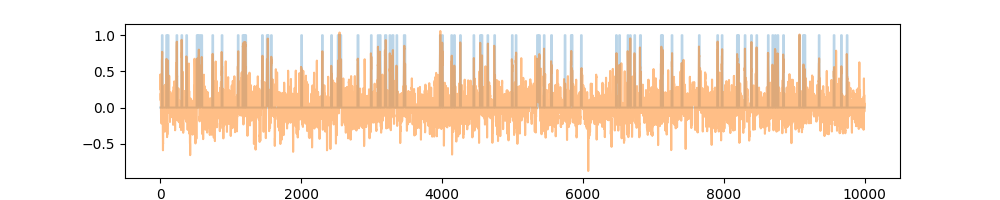

In [14]:
fig = plt.figure(figsize=(10, 2))
plt.plot(pixels_clean.mean(axis=0), alpha=0.3)
# plt.show()

# fig = plt.figure(figsize=(10, 2))
# plt.plot(pixels.mean(axis=0))
# # plt.show()

# fig = plt.figure(figsize=(10, 2))
# plt.plot(-v[0])
# plt.show()

# fig = plt.figure(figsize=(10, 2))
plt.plot(tdsvd.V[0] * 25, alpha=0.5)
plt.show()



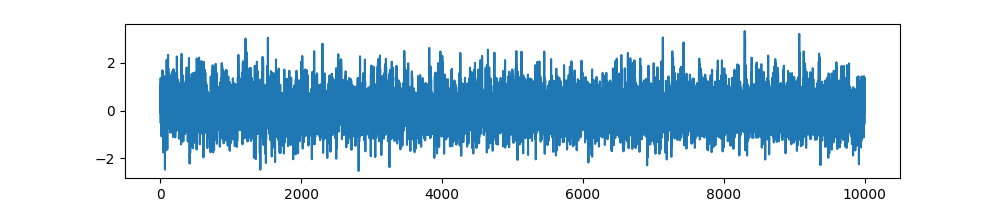

In [15]:
fig = plt.figure(figsize=(10, 2))
plt.plot(pixels.mean(axis=0))
plt.show()

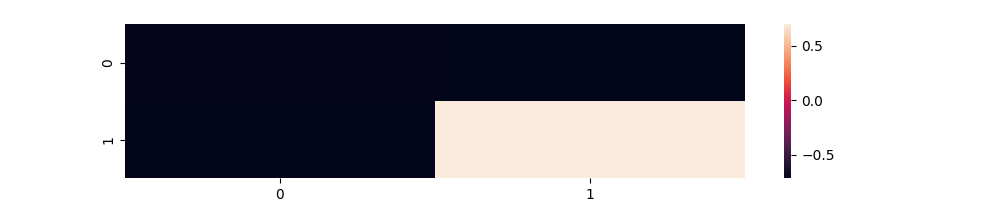

In [15]:
fig = plt.figure(figsize=(10, 2))
sns.heatmap(u)
plt.show()